In [8]:
# Import necessary libraries
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [9]:
# Path to the dataset
xray_dir = './xray'
normal_dir = os.path.join(xray_dir, 'normal')
pneumonia_dir = os.path.join(xray_dir, 'PNEUMONIA')

In [10]:
# Function to load and preprocess images
def load_images(image_dir, label):
    images = []
    labels = []
    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        try:
            # Load the image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128, 128))  # Resize to 128x128
            image = image / 255.0  # Normalize pixel values
            images.append(image)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    return np.array(images), np.array(labels)


In [11]:
# Load normal and pneumonia images
normal_images, normal_labels = load_images(normal_dir, 0)  # Label 0 for 'normal'
pneumonia_images, pneumonia_labels = load_images(pneumonia_dir, 1)  # Label 1 for 'PNEUMONIA'

# Combine datasets
X = np.concatenate([normal_images, pneumonia_images], axis=0)
y = np.concatenate([normal_labels, pneumonia_labels], axis=0)

# Add a channel dimension for CNN
X = X[..., np.newaxis]

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [12]:
# Function to compute fractal dimension
def fractal_dimension(binary_img):
    box_sizes = [2, 4, 8, 16, 32, 64]
    box_counts = []

    for size in box_sizes:
        count = 0
        padded_img = np.pad(binary_img, ((0, size - binary_img.shape[0] % size),
                                         (0, size - binary_img.shape[1] % size)),
                            mode='constant', constant_values=0)
        for i in range(0, padded_img.shape[0], size):
            for j in range(0, padded_img.shape[1], size):
                if np.any(padded_img[i:i + size, j:j + size]):
                    count += 1
        box_counts.append(count)

    coeffs = np.polyfit(np.log(box_sizes), np.log([count if count > 0 else 1e-10 for count in box_counts]), 1)
    return -coeffs[0]

# Compute fractal dimensions for training and testing data
X_train_fractal = np.array([fractal_dimension(image.squeeze()) for image in X_train])
X_test_fractal = np.array([fractal_dimension(image.squeeze()) for image in X_test])


In [ ]:
# Build the CNN using Sequential model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout to reduce overfitting

model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

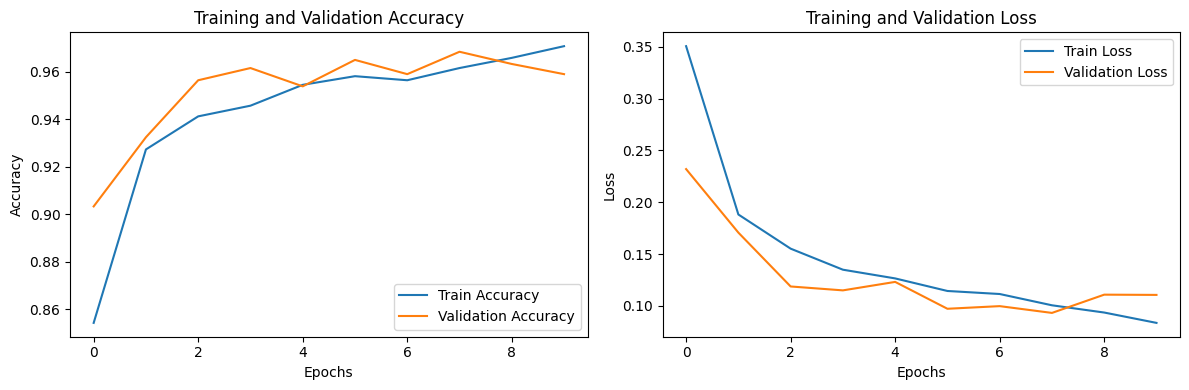

In [17]:
plt.figure(figsize=(12, 4))

# Plot accuracy (update key if needed)
plt.subplot(1, 2, 1)
plt.plot(history.history.get('accuracy', history.history.get('acc')), label='Train Accuracy')
plt.plot(history.history.get('val_accuracy', history.history.get('val_acc')), label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
# Save the trained model
model.save('xray_cnn_model.h5')
print("Model saved as xray_cnn_model.h5")


Model saved as xray_cnn_model.h5


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('xray_cnn_model.h5')
print("Model loaded successfully")


In [21]:
# Preprocess a single image for prediction

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    image = cv2.resize(image, (128, 128))  
    image = image / 255.0  
    return image.reshape(1, 128, 128, 1)  

# Example usage with a new image

image_path = './NORMAL2-IM-1431-0001.jpeg'  
new_image = preprocess_image(image_path)

# Make prediction using the loaded model

prediction = loaded_model.predict(new_image)
predicted_class = np.argmax(prediction)
print(f"Predicted Class: {'Pneumonia' if predicted_class == 1 else 'Normal'}")


Predicted Class: Normal
